Hello world!

This is my Notebook to analize Vietlott data.


# First: Get all data of Vietlott and save it to csv file:


In [ ]:
"""Vietlott data analysis
This is python code to analyze Vietlott data
"""

from bs4 import BeautifulSoup
from requests_html import HTMLSession
from selenium import webdriver
from datetime import datetime
import pandas

# Init Chrome to collect data
webdriver.chrome.driver = r"E:\setup\selenium\chromedriver_win32\chromedriver.exe"
driver = webdriver.Chrome()

###
# STEP 1: Get the current draw result.
###
current_result_link = "https://vietlott.vn/vi/trung-thuong/ket-qua-trung-thuong/655"
driver.get(current_result_link)

current_result_html = driver.page_source

# make BeautifulSoup
soup = BeautifulSoup(current_result_html, "html.parser")

# prettify the html
prettyHTML = soup.prettify()

# save the prettified html to a file
with open("current_result.html", "w", encoding="utf-8") as file:
    file.write(prettyHTML)

# Find the draw code and draw date
current_draw_code = soup.find('h5').find('b').get_text()
current_draw_date = soup.find('h5').find_all('b')[1].get_text()

# Find the list of numbers
current_lottery_number = [int(span.get_text()) for span in soup.find_all(
    'span', {'class': 'bong_tron small'})]

print(f"Current draw:\t\t{current_draw_code}")
print(f"Draw date:\t\t{current_draw_date}")
print(f"Current numbers:\t{current_lottery_number}")

###
# STEP 2: Get all history draw result and save it to csv.
###

CURRENT_DRAW = int(current_draw_code[1:])


class LotteryNumber:
    """
    A class represent a draw result
    Example of a declaration:
    my_lottery = LotteryNumber(901, '07/07/2023', [4, 8, 15, 16, 23, 42])
    """

    def __init__(self, code, date, numbers):
        self.code = code
        self.date = datetime.strptime(date, '%d/%m/%Y')
        self.numbers = numbers


# Get all Lottery result links
result_links = []
for i in range(1, CURRENT_DRAW + 1):
    link = f"https://vietlott.vn/vi/trung-thuong/ket-qua-trung-thuong/655?id={i:05}&nocatche=1#00001"
    result_links.append(link)

# Loop to get the data into a list of LotteryNumber objects
file_index = 1
result_data = []
for link in result_links:
    driver.get(link)

    result_html = driver.page_source

    # make BeautifulSoup
    soup = BeautifulSoup(result_html, "html.parser")

    # Find the draw code and draw date
    draw_code = soup.find('h5').find('b').get_text()
    draw_date = soup.find('h5').find_all('b')[1].get_text()
    # Find the list of numbers
    lottery_number = [int(span.get_text()) for span in soup.find_all(
        'span', {'class': 'bong_tron small'})]

    # prettify the html
    prettyHTML = soup.prettify()

    # save the prettified html to a file
    with open(f"html/{file_index}.html", "w", encoding="utf-8") as file:
        file.write(prettyHTML)

    # Add to the result_data list
    result_data.append(LotteryNumber(
        int(draw_code[1:]), draw_date, lottery_number))

    # Log to console
    print("Findind results:")
    print(f"Draw:\t\t{draw_code}")
    print(f"Draw date:\t\t{draw_date}")
    print(f"Numbers:\t\t{lottery_number}")

    # Create a list of dictionaries containing the data from the result_data list
    data = [{'code': lottery.code,
            'date': lottery.date.strftime('%d/%m/%Y'),
             'number 1': lottery.numbers[0],
             'number 2': lottery.numbers[1],
             'number 3': lottery.numbers[2],
             'number 4': lottery.numbers[3],
             'number 5': lottery.numbers[4],
             'number 6': lottery.numbers[5], } for lottery in result_data]

    # Create a DataFrame from the data
    df = pd.DataFrame(data)

    # Write the DataFrame to a CSV file
    df.to_csv('result_data.csv', index=False)

    # Increase file_index
    file_index += 1

###
# STEP 3: Analyze the data.
###

# Exit Chrome
driver.quit()


# Then: Process the data:


In [ ]:
!pip install matplotlib

No days have the same 6 numbers


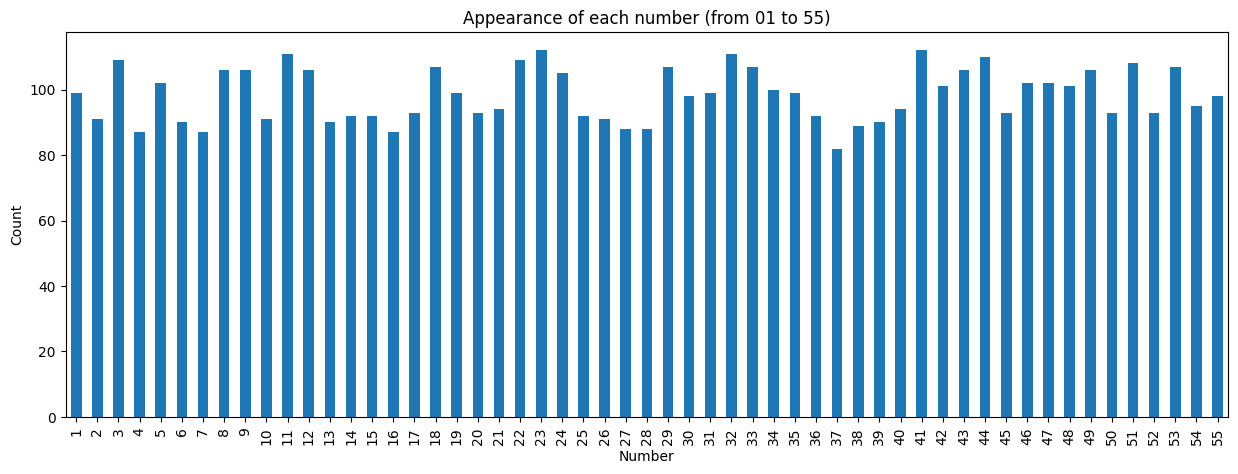

6 numbers appear most frequently: [23, 41, 11, 32, 44, 3]
6 numbers appear least frequently: [37, 4, 7, 16, 27, 28]
6 numbers appear most frequently in last 30 days: [11, 23, 50, 7, 12, 13]
6 numbers appear least frequently in last 30 days: [1, 9, 15, 17, 18, 20]
6 numbers appear most frequently in last 365 days: [23, 13, 1, 8, 52, 14]
6 numbers appear least frequently in last 365 days: [26, 16, 7, 49, 25, 31]
6 numbers appear most frequently in this month: [13, 23, 33, 50, 4, 7]
6 numbers appear least frequently in this month: [4, 7, 8, 11, 12, 14]
6 numbers appear most frequently in this year: [23, 14, 1, 33, 43, 12]
6 numbers appear least frequently in this year: [26, 42, 16, 19, 20, 25]


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
data = pd.read_csv('result_data.csv', parse_dates=['date'], dayfirst=True)

# Find if days have the same 6 numbers
data['numbers'] = data[['number 1', 'number 2', 'number 3', 'number 4', 'number 5', 'number 6']].apply(lambda x: set(x), axis=1)
duplicates = data.duplicated(subset='numbers', keep=False)
if duplicates.any():
    print('Days with the same 6 numbers:')
    print(data.loc[duplicates, ['date', 'numbers']])
else:
    print('No days have the same 6 numbers')

# Draw the graph of appearance of each number (from 01 to 55)
counts = pd.Series()
for i in range(1, 7):
    counts = counts.add(data[f'number {i}'].value_counts(), fill_value=0)
counts = counts.sort_index().astype(int)
counts.plot(kind='bar', figsize=(15,5))
plt.title('Appearance of each number (from 01 to 55)')
plt.xlabel('Number')
plt.ylabel('Count')
plt.show()

# Which 6 numbers appear most frequently, which 6 numbers appear least frequently
print('6 numbers appear most frequently:', counts.nlargest(6).index.tolist())
print('6 numbers appear least frequently:', counts.nsmallest(6).index.tolist())

# Which 6 numbers appear most frequently, which 6 numbers appear least frequently in last 30 days, last 365 days, this month, this year
today = pd.to_datetime('today')
for days in [30, 365]:
    start_date = today - pd.Timedelta(days=days)
    mask = data['date'] >= start_date
    counts = pd.Series()
    for i in range(1, 7):
        counts = counts.add(data.loc[mask, f'number {i}'].value_counts(), fill_value=0)
    counts = counts.sort_index().astype(int)
    print(f'6 numbers appear most frequently in last {days} days:', counts.nlargest(6).index.tolist())
    print(f'6 numbers appear least frequently in last {days} days:', counts.nsmallest(6).index.tolist())

for period in ['M', 'Y']:
    start_date = today.to_period(period).to_timestamp()
    mask = data['date'] >= start_date
    counts = pd.Series()
    for i in range(1, 7):
        counts = counts.add(data.loc[mask, f'number {i}'].value_counts(), fill_value=0)
    counts = counts.sort_index().astype(int)
    period_name = 'this month' if period == 'M' else 'this year'
    print(f'6 numbers appear most frequently in {period_name}:', counts.nlargest(6).index.tolist())
    print(f'6 numbers appear least frequently in {period_name}:', counts.nsmallest(6).index.tolist())


Now I just want to prettify the result.

All time:
- Most frequently: 23, 41, 11, 32, 44, 3
- Least frequently: 37, 4, 7, 16, 27, 28

In last 30 days:
- Most frequently: 11, 23, 50, 7, 12, 13
- Least frequently: 1, 9, 15, 17, 18, 20

In last 365 days:
- Most frequently: 23, 13, 1, 8, 52, 14
- Least frequently: 26, 16, 7, 49, 25, 31

In this year:
- Most frequently: 23, 14, 1, 33, 43, 12
- Least frequently: 26, 42, 16, 19, 20, 25

In this month:
- Most frequently: 13, 23, 33, 50, 4, 7
- Least frequently: 4, 7, 8, 11, 12, 14
